# Predicting Newsletter Subscription from Player Age in a Minecraft Research Server


# Introduction:

In this course, we complete a full data science project from beginning to end and communicate the entire workflow in a single Jupyter Notebook. The notebook combines code cells and Markdown cells: code cells are used to download the data, wrangle and clean it in a reproducible way, perform exploratory analysis and fit predictive models; Markdown cells narrate our methods, explain the question being asked,  methodological choices, and summarize the conclusions. The notebook functions both as an executable analysis script and as a written report that another reader can understand from top to bottom.

The data for this project comes from a research group in Computer Science at the University of British Columbia that operates a custom Minecraft server, PLAICraft. Players can join this server and explore a shared open-world. Importantly, Minecraft has a lack of specific goals or story beats present in most other games, allowing players to progress in any way they want. This highlights Minecraft's forte in research of human behaviour in video games. The PLAICraft team collects information about who joins the server and how they play. Running such a study is logistically challenging: the team must recruit enough players to obtain useful data, but they must also ensure that they have enough technical resources to support those players. Understanding which kinds of players are most engaged with the project is therefore important.

The PLAICraft team runs a blog that players can subscribe to (https://blog.plaicraft.ai/). Players who subscribe are more likely to be interested in future updates and may be more inclined to return to the server, participate in follow-up experiments, or respond to surveys. Being able to predict which players are likely to subscribe could help them target participation recruitment  (for example, to specific age groups) and improve efficiency of data retrieval.

In this report we focus on the following question:

> **Can we predict whether a player subscribes to the newsletter based on their age?**

To address this question, we use the `players.csv` data set. This file is a player-level summary: it contains one row for each player who joined the Minecraft server. In total, there are 196 players and 7 variables:

- `experience`: the player’s Minecraft experience level (e.g., “beginner”, “intermediate”, “expert”), which is self-reported in surveys;
- `hashedEmail`: an anonymized identifier derived from the player’s email address, used to link records without revealing personal information;
- `name`: the player’s name;
- `gender`: the player’s gender;
- `played_hours`: the total number of hours the player has spent on the server;
- `Age`: the player’s age in years (numeric);
- `subscribe`: whether the player subscribed to the newsletter (`TRUE` for subscribed, `FALSE` for not subscribed).

For our main analysis we focus on `Age` as the explanatory variable and `subscribe` as the binary response variable. We begin by cleaning the `players.csv` data: we remove players with missing age or subscription information and convert `subscribe` into a factor with levels *No* and *Yes* for ease of visualization and modelling. This gives a cleaned data set of 194 players. We then compute summary statistics and create exploratory visualizations to understand how newsletter subscription rates vary across age groups. Finally, we fit and evaluate a K-nearest neighbours classification model that uses age to predict whether a player subscribes to the newsletter, and we discuss what the results suggest about the role of age in player engagement on the Minecraft server.


# Methods and Code: 

All of the analysis was carried out in R using the `tidyverse` and `tidymodels` packages inside a Jupyter Notebook, so that the workflow is fully reproducible.


In [1]:
library(tidyverse)
library(tidymodels)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

We began by loading the main packages needed for the project: tidyverse for data wrangling and visualization, tidymodels for modelling, and ggplot2 for plotting. We then loaded the players.csv data directly from a GitHub URL using read_csv. Loading the data from a URL ensures that anyone running the notebook will read exactly the same dataset without needing any local files. After reading the data we confirmed that there were 196 players and 7 variables, including Age (numeric), subscribe (logical), and several additional demographic and experience variables.

In [2]:
players <- read_csv("https://raw.githubusercontent.com/calentynes/dsci_group_project/refs/heads/master/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Next, we created a cleaned player-level dataset that contained only the variables relevant for this project: `Age` and `subscribe`. Using `filter`, we removed any rows where age or subscription status was missing (`is.na(Age)` or `is.na(subscribe)`), because our model cannot be trained on players without age information or a known subscription outcome. We then used `mutate` to convert `subscribe` from a logical variable (`TRUE` / `FALSE`) into a factor with two levels, labelled *No* and *Yes*. This factor format is convenient for both plotting and classification models.


In [3]:
players_age <- players |> 
  filter(!is.na(Age),
         !is.na(subscribe)) |>
  mutate(
    subscribe = factor(subscribe,
                       levels = c(FALSE, TRUE),
                       labels = c("No", "Yes"))
          ) 



To explore how newsletter subscription varies with age, we created an age-group variable and a corresponding visualization. Using mutate and cut, we grouped players into 5-year age bands from 5 to 60 years (for example, 5–10, 10–15, and so on). We then used ggplot with `geom_bar(position = "fill")` to produce a stacked bar chart that shows, for each age group, the proportion of players who subscribed and did not subscribe. The y-axis was formatted as percentages using `scale_y_continuous(labels = scales::percent)`, and we added informative axis labels and a descriptive title. This plot (Figure 1) helps visualize whether younger and older players differ in their subscription behaviour.

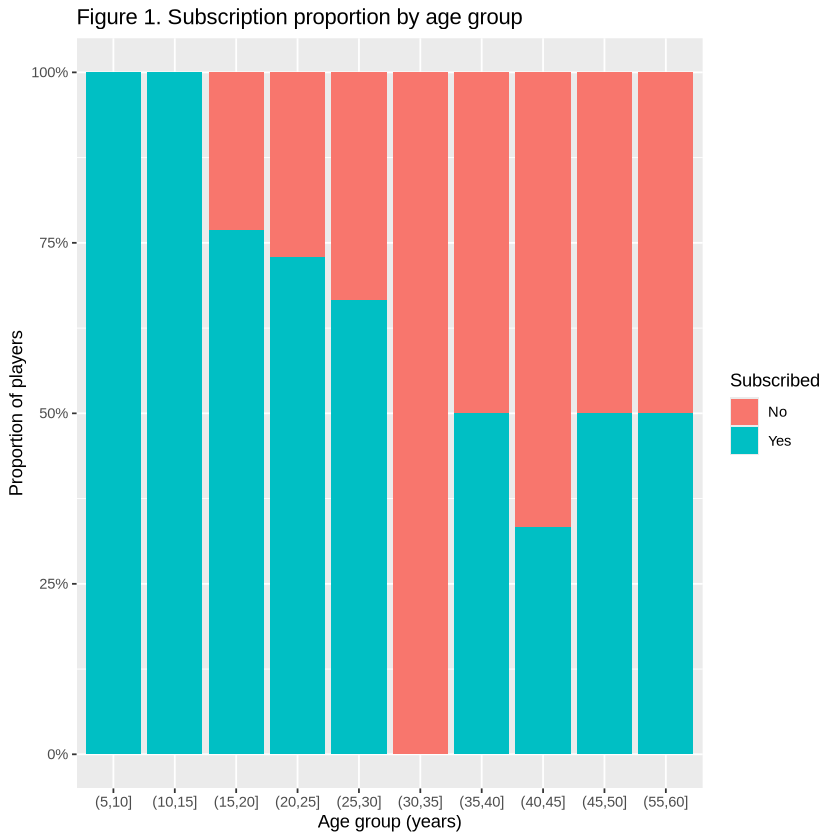

In [4]:
p_age <- players_age |>
  mutate(age_group = cut(Age,
                         breaks = seq(5, 60, by = 5),
                         right = TRUE)) |>
  ggplot(aes(x = age_group, fill = subscribe)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent) +
  labs(
    title = "Figure 1. Subscription proportion by age group",
    x = "Age group (years)",
    y = "Proportion of players",
    fill = "Subscribed"
  )

p_age

For the modelling part of the analysis, we framed our problem as a binary classification task, where the goal is to predict subscribe (Yes/No) from Age. We adopted the K-nearest neighbours (K-NN) classification model rather than a linear or K-NN regression model since we want to predict a discrete category instead of a continuous value. 

First, we split the cleaned data into a training set and a test set using `initial_split(players_age, prop = 0.8, strata = subscribe)`. The prop = 0.8 argument assigns approximately 80% of the players to the training set and 20% to the test set, while strata = subscribe ensures that both sets have similar proportions of subscribers and non-subscribers. We then used `training()` and `testing()` to extract the players_train and players_test datasets from this split.

On the training data, we built a preprocessing recipe that specified `subscribe ~ Age` to indicate that Age is our predictor and subscribe is the response. We then added a normalization step, `step_normalize(all_predictors())`, which centers and scales the age variable so that it has mean 0 and standard deviation 1. Normalizing predictors is important for K-NN because the algorithm is based on distances between observations; without normalization, predictors on larger scales could dominate the distance calculations.

In [5]:
set.seed(123)

players_split <- initial_split(players_age, prop = 0.8, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

subscribe_recipe <- recipe(subscribe ~ Age, data = players_train) |>
  step_normalize(all_predictors())


In order to have a good prective model, we must find the best K-value.
We then defined a K-NN model specification using `nearest_neighbor(weight_func = "rectangular", neighbors = tune())`, and set the engine to "kknn" and the mode to "classification" with `set_engine("kknn")` and `set_mode("classification")`. The `neighbors = tune()` argument indicates that the number of neighbours, k, is a tuning parameter that we will select using cross-validation. To do this, we created a 5-fold cross-validation object with `vfold_cv(players_train, v = 5, strata = subscribe)`, which splits the training data into five folds while preserving the subscription class proportions in each fold.

In [6]:

knn_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors   = tune()
  ) |>
  set_engine("kknn") |>
  set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

players_wflow <- workflow() |>
  add_recipe(subscribe_recipe) |>
  add_model(knn_spec)

grid_k <- tibble(neighbors = seq(1, 51, by = 2))

set.seed(123)
knn_results <- players_wflow |>
  tune_grid(resamples = players_vfold,
            grid      = grid_k) |>
  collect_metrics()



Next, we combined the recipe and model specification into a single workflow using `workflow() |> add_recipe(subscribe_recipe) |> add_model(knn_spec)`. We also created a grid of candidate \(k\) values (odd integers between 1 and 51) using `tibble(neighbors = seq(1, 51, by = 2))`. Using `tune_grid`, we trained and evaluated K-NN models with each value of \(k\) across the cross-validation folds, and collected the results with `collect_metrics()`. This produced a table (`knn_results`) containing, for each \(k\), the mean cross-validated accuracy and related statistics. We then filtered this table to keep only the rows where `.metric == "accuracy"`, and produced Figure 2 to show which shows us that at $K=31$, the accuracy estimate is the greatest.

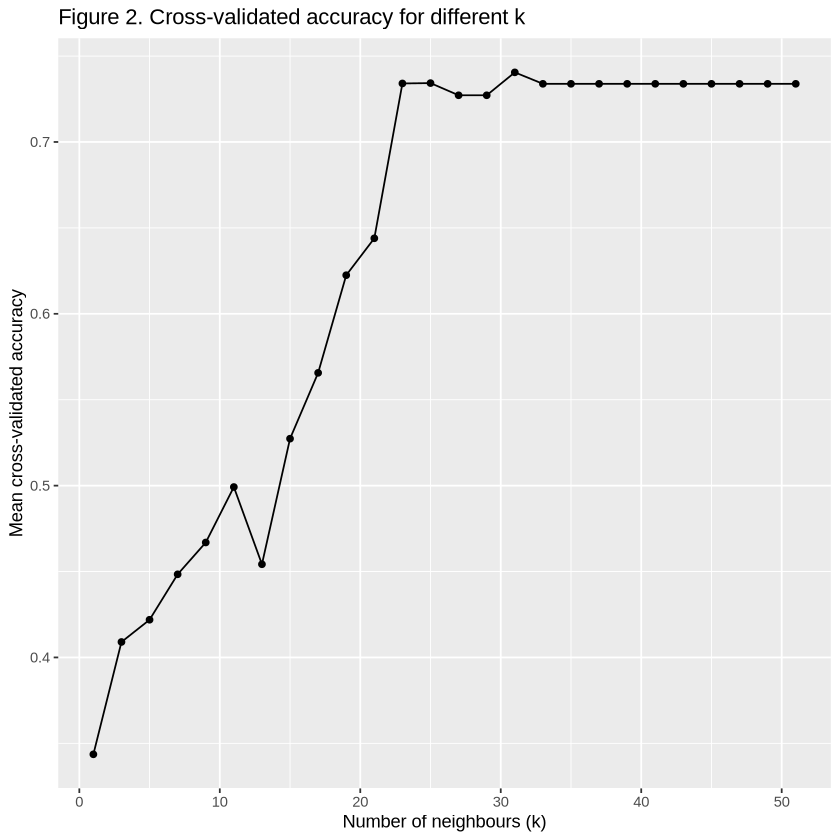

In [7]:
knn_accuracy <- knn_results |>
  filter(.metric == "accuracy")

knn_accuracy_plot <- knn_accuracy |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Figure 2. Cross-validated accuracy for different k",
    x = "Number of neighbours (k)",
    y = "Mean cross-validated accuracy"
  )

knn_accuracy_plot

To confirm this, we used `slice_max(mean, n = 1)` to select the value of \(k\) with the highest mean accuracy. This best-performing value of \(k\), stored in `best_k`, was carried forward to the final model.

In [8]:
best_k <- knn_results |>
  filter(.metric == "accuracy") |>
  slice_max(mean, n = 1, with_ties = FALSE) |>
  pull(neighbors)
best_k

[1] 31

Here we use the cross-validation results to choose the “best” value of k. filter(.metric == "accuracy") keeps only the rows where the performance metric is accuracy. slice_max(mean, n = 1, with_ties = FALSE) finds the single row with the largest mean accuracy. pull(neighbors) takes the value in the neighbors column from that row and stores it in the variable best_k.

In [9]:
final_knn_spec <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors   = best_k
) |>
  set_engine("kknn") |>
  set_mode("classification")

This code defines the “final” K-NN model using the tuned value `best_k`. We set the number of neighbours to best_k, choose the kknn engine, and declare that the task is classification. In the context of the whole project, this step turns the best hyperparameter chosen by cross-validation into an actual model specification that can be fitted and used for prediction; all later fitting and prediction steps are based on this `final_knn_spec`.

In [10]:
final_wflow <- workflow() |>
  add_recipe(subscribe_recipe) |>
  add_model(final_knn_spec)

This code combines the preprocessing recipe subscribe_recipe and the final K-NN model into a single workflow called final_wflow. The purpose is to bundle “preprocessing (e.g., normalizing Age)” and “fitting the K-NN model” into one unified pipeline. After this, whenever we use the workflow on training or test data, the same sequence of steps is applied automatically, keeping the modelling process clean and reproducible.

In [11]:
final_fit <- final_wflow |>
  fit(data = players_train)

This line is where we actually train the model: we fit the workflow on the training set `players_train` and obtain a fitted object called `final_fit`. During this process, R first applies the preprocessing steps from the recipe (such as normalization) and then trains the K-NN model on the processed features. In the project as a whole, `final_fit` is the trained model itself; all later test-set predictions, confusion matrices, and accuracy calculations depend on this object.

In [12]:
test_pred <- predict(final_fit, players_test, type = "prob") |>
  bind_cols(
    predict(final_fit, players_test),
    players_test |> select(subscribe, Age)
  )

head(test_pred)

.pred_No,.pred_Yes,.pred_class,subscribe,Age
<dbl>,<dbl>,<fct>,<fct>,<dbl>
0.3548387,0.6451613,Yes,Yes,17
0.3548387,0.6451613,Yes,No,17
0.1935484,0.8064516,Yes,No,21
0.3548387,0.6451613,Yes,Yes,17
0.4516129,0.5483871,Yes,Yes,58
0.5161290,0.4838710,No,No,18


This block produces predictions on the test set players_test and organizes all key information into a data frame test_pred. We first call `predict` to obtain the predicted probabilities for subscribing and not subscribing, then call `predict(final_fit, players_test)` again to get the predicted class labels (Yes/No), and finally use `bind_cols()` to combine these predictions with the true subscription labels and Age.

In [13]:
test_metrics <- metrics(
  data    = test_pred,
  truth   = subscribe,
  estimate = .pred_class
) |>
  filter(.metric == "accuracy")

test_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75


`. metrics(data = test_pred, truth = subscribe, estimate = .pred_class)` uses the true labels subscribe and the predicted class labels .pred_class from test_pred to calculate several performance measures. Then `filter(.metric == "accuracy")` keeps only the row corresponding to accuracy and stores it in test_metrics. Printing test_metrics shows the accuracy of our model. In the project, this step provides a simple, interpretable number that summarizes how well the K-NN classifier based only on age performs on new, unseen players.

## Discussion

In this project we investigated whether a player’s age can be used to predict whether they subscribe to a game-related newsletter on a Minecraft research server. Our goal was not only to build a classifier, but also to understand how strongly age is related to subscription behaviour.

The exploratory analysis suggested a generally negative relationship between age and subscription. As age increases, the proportion of players subscribed decreases. In the stacked bar chart by age group (Figure 1), nearly 70% subscribe to the newsletter for all age groups below 30. In contrast, subscription rates in age groups above 30 years old are noticeably lower, closer to 50%. This pattern indicates that age and subscription are related: younger players are more likely to subscribe than older players.

The K-NN classification model utilizes distance to quantify how strong the relationship between age and subscription is. Using only `Age` as a predictor and tuning the number of neighbours with 5-fold cross-validation, we obtained a best model with \(K = 31\). On the held-out test set, this model achieved an accuracy of about 0.75, meaning that it correctly predicted subscription status for roughly three quarters of the players. At first glance this seems fairly good, but it must be compared to an appropriate baseline. In our test data, about three quarters of players subscribed to the newsletter; a naive model that always predicts “Yes” for everyone would therefore reach an accuracy of around 0.73. The K-NN model improves on this naive baseline, but only slightly. This tells us that age does carry some predictive information about subscription, but the relationship is not very strong: knowing a player’s age helps a little, but it is far from sufficient to predict subscription reliably.

From the perspective of the research group, these results have two main implications. First, age does matter to some extent: younger players are more likely to subscribe, and a very simple model based only on age can already do slightly better than always guessing the majority class. Second, and more importantly, age alone is not a strong enough signal to support precise targeting. If the goal is to identify highly engaged players or to decide who should receive special recruitment messages, relying only on age would lead to many false positives among non-subscribers. To build a more useful predictive model, additional features are needed. A natural next step would be to incorporate behavioural variables that better capture player engagement, such as total hours played, number of sessions, or patterns in the `sessions.csv` data. Combining age with these behavioural predictors in a multivariable model would likely increase predictive performance and provide a clearer picture of which kinds of players are most likely to subscribe to the . 

It would also be interesting to explore other methods introduced in the course—such as K-NN with multiple predictors or simple linear models for numerical outcomes—to compare their performance. Finally, using bootstrap methods to obtain confidence intervals for the test accuracy could quantify the uncertainty in our results and show how much the performance might vary for different random splits of the data.